In [1]:
import numpy as np
import open3d as o3d
from tools import load, project, camera
# auto reload packages
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Visualize point cloud from lidar data
## Load Data
First go to the [IGN geoservice](https://geoservices.ign.fr/lidarhd) website.  
Select the desired tiles in the interactive map and download the url list as a txt file.  

In [2]:
datadir = "./data/MNS/"
# can take time, needed only once
#load.download_and_load(datadir, datadir+"liste_dalle_extended.txt", 10000)
#pc = load.load_pcd(datadir, "saved_terrain_customname")

In [3]:
# import pcd file
pc = o3d.io.read_point_cloud(datadir+"saved_terrain_15x15_extended.pcd")

In [4]:
# display test
o3d.visualization.draw_geometries([pc])

## Define view point

In [5]:
lat = 44.5451545715
lon = 4.2165341377
altitude=780
view_point = project.to_lambert93(lat, lon, altitude)

In [6]:
# Add a sphere at view point
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=15)
sphere.translate(view_point)

TriangleMesh with 762 points and 1520 triangles.

In [7]:
width = 1280
height = 720
# read camera parameters
parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
# change intrinsic and extrinsinc matrices in this file
# for example, the following function compute the focal length in pixels from the camera parameters
camera.get_focal_length_px(4, 1280, 720, 1/2.49)

(914.206475584154, 914.2064755841538)

In [8]:
# example to set the camera to the registered location
vis = o3d.visualization.Visualizer()
vis.create_window(width=width, height=height)
vis.add_geometry(pc)
vis.add_geometry(sphere)
#vis.set_full_screen(True)
vis.get_view_control().convert_from_pinhole_camera_parameters(parameters, True)
vis.run()
vis.destroy_window()

## Set camera actions

Register camera position (to do once per viewpoint):
- place camera vertically to have viewpoint around the center (eventually use U)
- use L to lock the viewpoint direction
- use T to translate until viewpoint is reached
- use P to save the camera parameters

Place camera to viewpoint:
- use V to set view
- use left/right arrows to rotate until desired view is obtained

In [9]:
key_to_callback = camera.callbacks(parameters, view_point)
o3d.visualization.draw_geometries_with_key_callbacks([pc, sphere], key_to_callback, width=width, height=height)

## Extract skyline
Based on [A New Method of Improving the Azimuth in Mountainous Terrain by Skyline Matching](https://link.springer.com/article/10.1007/s41064-020-00093-1) by Nagy Balázs (2019)

In [16]:
spherical = project.array_cartesian_to_spherical(pc.points, view_point)
angles = project.get_deg_angles(spherical)

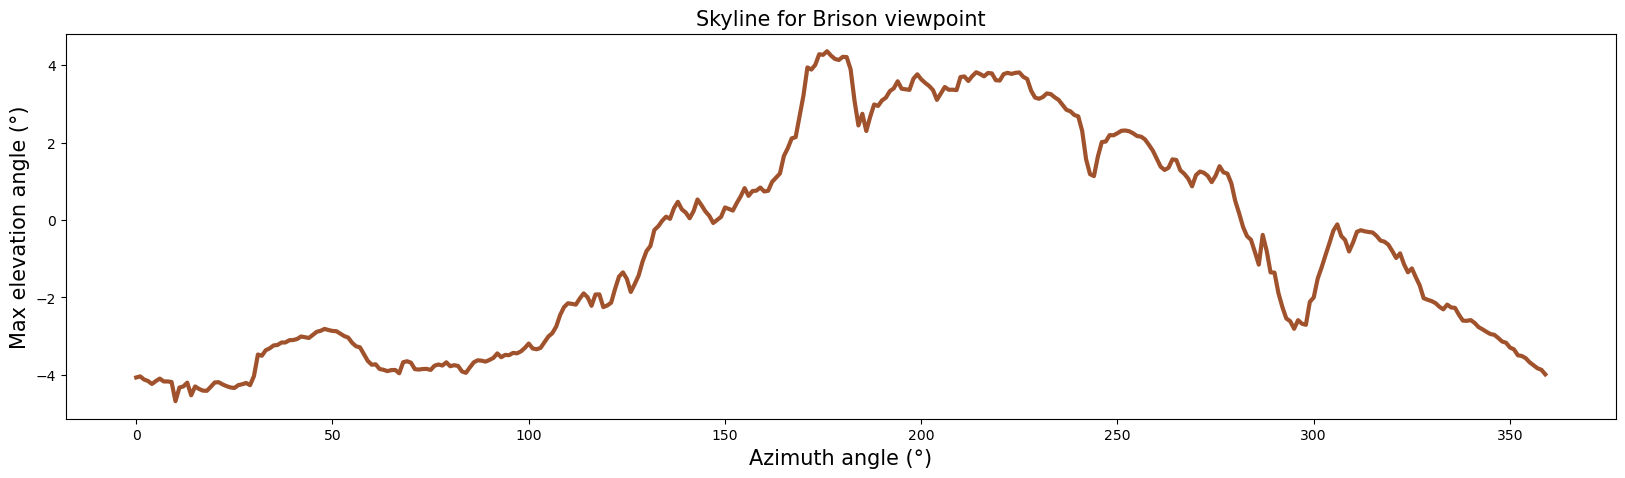

In [17]:
skyline = project.get_skyline(angles)
project.plot_skyline(skyline, 'Skyline for Brison viewpoint')

## Project skyline on terrain
![](./data/plots/skyline_terrain.png)

In [18]:
max_z = np.max(np.asarray(pc.points)[:,2])
skyline_points = project.skyline_to_cartesian(spherical, angles, skyline, view_point, max_z)

In [20]:
camera.save_skyline_with_terrain(pc, skyline_points, './data/plots/skyline_terrain.png')

Image saved at ./data/plots/skyline_terrain.png
